<h1><center>Reviews Sentiment Analysis</center></h1>
<h3><center>Sentiment Analysis of the reviews on Olist</center></h3>

Đánh giá và xếp hạng được đưa ra cho các sản phẩm được bán trên trang web Olist. Những đánh giá này có thể được sử dụng để hiểu cảm nhận của người đánh giá đối với một sản phẩm. Những cảm xúc này có thể giúp nhận ra các sản phẩm phổ biến trên trang web Olist.



In [54]:
import gdown

utilities_id = '1ho5VPTWlXW8FHWfUdanvl11xDLtYlkUf'
gdown.download_folder(id=utilities_id, quiet=True)

['/content/sentiment/custom_transformers.py',
 '/content/sentiment/ml_utils.py',
 '/content/sentiment/text_utils.py',
 '/content/sentiment/viz_utils.py']

In [55]:
file_id = '1_8Zdnq5Jo_yakab3kuQ0GPzpVu5nuMph'
output_path = 'olist_order_reviews_dataset.csv'
gdown.download(id=file_id, output=output_path, quiet=True, fuzzy=True)

'olist_order_reviews_dataset.csv'

In [56]:
# Download required library
!pip install -q shap

# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
import sys
import os

# Utilities
sys.path.append('/content/sentiment/')
from viz_utils import *
from custom_transformers import *
from ml_utils import *

# DataPrep
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Data Understanding

In [57]:
olist_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')

In [58]:
df_comments = olist_order_reviews.loc[:, ['review_score', 'review_comment_message']]
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)
print(f'Dataset shape: {df_comments.shape}')
df_comments.columns = ['score', 'comment']
df_comments

Dataset shape: (40966, 2)


,score,comment
0,5,I received it well before the stipulated deadl...
1,5,Congratulations lannister stores I loved shopp...
2,4,efficient device. On the website the brand of ...
3,4,"But a little slow...for the price, it's good.\n"
4,5,"Reliable seller, ok product and delivery on time."
...,...,...
40961,4,For this product I received it in accordance w...
40962,5,Delivered within the deadline. The product arr...
40963,3,"The product was not sent with an NF, there is ..."
40964,5,"Excellent backpack, super fast delivery. I hig..."


## Regular Expressions

In [59]:
def find_patterns(re_pattern, text_list):
    """
    Args:
    ---------
    re_pattern: regular expression pattern to be used on search [type: string]
    text_list: list with text strings [type: list]

    Returns:
    positions_dict: python dictionary with key-value pars as below:
        text_idx: [(start_pattern1, end_pattern1), (start_pattern1, end_pattern2), ... (start_n, end_n)]
    """

    # Compiling the Regular Expression passed as a arg
    p = re.compile(re_pattern)
    positions_dict = {}
    i = 0
    for c in text_list:
        match_list = []
        iterator = p.finditer(c)
        for match in iterator:
            match_list.concat(match.span())
        control_key = f'Text idx {i}'
        if len(match_list) == 0:
            pass
        else:
            positions_dict[control_key] = match_list
        i += 1

    """p = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    pattern_dict = find_patterns(p, reviews_breakline)
    print(len(pattern_dict))
    pattern_dict
    for idx in [int(c.split(' ')[-1]) for c in list(pattern_dict.keys())]:
        print(f'{reviews_breakline[idx]}\n')"""

    return positions_dict

def print_step_result(text_list_before, text_list_after, idx_list):
    """
    Args:
    ----------
    text_list_before: list object with text content before transformation [type: list]
    text_list_after: list object with text content after transformation [type: list]
    idx_list: list object with indexes to be printed [type: list]
    """

    # Iterating over string examples
    i = 1
    for idx in idx_list:
        print(f'--- Text {i} ---\n')
        print(f'Before: \n{text_list_before[idx]}\n')
        print(f'After: \n{text_list_after[idx]}\n')
        i += 1

### Breakline and Carriage Return

In [60]:
def re_breakline(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """

    # Applying regex
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

In [61]:
# Creating a list of comment reviews
reviews = df_comments['comment'].to_list()

# Applying RegEx
reviews_breakline = re_breakline(reviews)
df_comments['re_breakline'] = reviews_breakline

# Verifying results
print_step_result(reviews, reviews_breakline, idx_list=[48])

--- Text 1 ---

Before: 
There was only one product missing, I received it today, thank you very much!
All very well!

Att

Elenice.

After: 
There was only one product missing, I received it today, thank you very much! All very well!  Att  Elenice.



### Sites and Hiperlinks

In [62]:
def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """

    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

In [63]:
# Applying RegEx
reviews_hiperlinks = re_hiperlinks(reviews_breakline)
df_comments['re_hiperlinks'] = reviews_hiperlinks

# Verifying results
print_step_result(reviews_breakline, reviews_hiperlinks, idx_list=[10796, 12782])

--- Text 1 ---

Before: 
The product was delivered, but was refused, as it had already been canceled due to having purchased the wrong size!

After: 
The product was delivered, but was refused, as it had already been canceled due to having purchased the wrong size!

--- Text 2 ---

Before: 
I still haven't received my order and I don't even know why I'm very dissatisfied.

After: 
I still haven't received my order and I don't even know why I'm very dissatisfied.



### Dates

In [64]:
def re_dates(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """

    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]

In [65]:
# Applying RegEx
reviews_dates = re_dates(reviews_hiperlinks)
df_comments['re_dates'] = reviews_dates

# Verifying results
print_step_result(reviews_hiperlinks, reviews_dates, idx_list=[26665, 40710, 40887])

--- Text 1 ---

Before: 
product received in good condition and on time

After: 
product received in good condition and on time

--- Text 2 ---

Before: 
Great store to shop, I recommend it.

After: 
Great store to shop, I recommend it.

--- Text 3 ---

Before: 
Product was delivered quickly, I highly recommend it....

After: 
Product was delivered quickly, I highly recommend it....



### Money

In [66]:
def re_money(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """

    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' money ', r) for r in text_list]

In [67]:
# Applying RegEx
reviews_money = re_money(reviews_dates)
df_comments['re_money'] = reviews_money

# Verifying results
print_step_result(reviews_dates, reviews_money, idx_list=[26020, 33297, 32998])

--- Text 1 ---

Before: 
Congratulations on your commitment to customers, thank you

After: 
Congratulations on your commitment to customers, thank you

--- Text 2 ---

Before: 
It met expectations. It took a while.

After: 
It met expectations. It took a while.

--- Text 3 ---

Before: 
The product was only half delivered, I bought two rolls of wallpaper and only one roll was delivered.

After: 
The product was only half delivered, I bought two rolls of wallpaper and only one roll was delivered.



### Numbers

In [68]:
def re_numbers(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """

    # Applying regex
    return [re.sub('[0-9]+', ' number ', r) for r in text_list]

In [69]:
# Applying RegEx
reviews_numbers = re_numbers(reviews_money)
df_comments['re_numbers'] = reviews_numbers

# Verifying results
print_step_result(reviews_money, reviews_numbers, idx_list=[68])

--- Text 1 ---

Before: 
I purchased the product on February 25th and today, March 29th, it had not been delivered to my home. I don't know if the post office in Brazil is terrible or if it was the store itself that took so long to post.

After: 
I purchased the product on February  number th and today, March  number th, it had not been delivered to my home. I don't know if the post office in Brazil is terrible or if it was the store itself that took so long to post.



### Negation

In [70]:
def re_negation(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """

    # Applying regex
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negation ', r) for r in text_list]

In [71]:
# Applying RegEx
reviews_negation = re_negation(reviews_numbers)
df_comments['re_negation'] = reviews_negation

# Verifying results
print_step_result(reviews_numbers, reviews_negation, idx_list=[38, 247, 1396, 2401])

--- Text 1 ---

Before: 
I asked for a refund and no response yet.

After: 
I asked for a refund and no response yet.

--- Text 2 ---

Before: 
The price was great, the delivery time was long (more than  number  month to deliver). I bought  number  cartridges and they only delivered  number , I complained and they sent the other within the delivery time.

After: 
The price was great, the delivery time was long (more than  number  month to deliver). I bought  number  cartridges and they only delivered  number , I complained and they sent the other within the delivery time.

--- Text 3 ---

Before: 
Satisfied!

After: 
Satisfied!

--- Text 4 ---

Before: 
I bought  number  hp ce number a toner and only received  number  and they still issued the invoice with  number  products. I'm still waiting for the delivery of the second toner, I've already contacted Targaryen and they haven't gotten back to me yet.

After: 
I bought  number  hp ce number a toner and only received  number  and they s

### Special Characters

In [72]:
def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """

    # Applying regex
    return [re.sub('\W', ' ', r) for r in text_list]

In [73]:
# Applying RegEx
reviews_special_chars = re_special_chars(reviews_negation)
df_comments['re_special_chars'] = reviews_special_chars

# Verifying results
print_step_result(reviews_negation, reviews_special_chars, idx_list=[45, 135, 234])

--- Text 1 ---

Before: 
This was the request Bucket with  number  Pieces - Building Blocks  number  units -  money  each (NOT DELIVERED) Sold and delivered targaryen Eva Rug No. Letters  number  Pieces Children  number  unit -  money  (THIS WAS DELIVERED

After: 
This was the request Bucket with  number  Pieces   Building Blocks  number  units    money  each  NOT DELIVERED  Sold and delivered targaryen Eva Rug No  Letters  number  Pieces Children  number  unit    money   THIS WAS DELIVERED

--- Text 2 ---

Before: 
Product I do not recommend not reading on any device

After: 
Product I do not recommend not reading on any device

--- Text 3 ---

Before: 
Great quality product. I loved!

After: 
Great quality product  I loved 



### Additional Whitespaces

In [74]:
def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """

    # Applying regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

In [75]:
# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
df_comments['re_whitespaces'] = reviews_whitespaces

# Verifying results
print_step_result(reviews_special_chars, reviews_whitespaces, idx_list=[3, 4, -1])

--- Text 1 ---

Before: 
But a little slow   for the price  it s good  

After: 
But a little slow for the price it s good

--- Text 2 ---

Before: 
Reliable seller  ok product and delivery on time 

After: 
Reliable seller ok product and delivery on time

--- Text 3 ---

Before: 
My product arrived and I already have to return it  because it is defective  it does not hold the charge

After: 
My product arrived and I already have to return it because it is defective it does not hold the charge



## Stopwords

In [76]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [77]:
# Examples of some english stopwords
pt_stopwords = stopwords.words('english')
print(f'Total enlgish stopwords in the nltk.corpous module: {len(pt_stopwords)}')
pt_stopwords[:10]

Total enlgish stopwords in the nltk.corpous module: 179


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [78]:
# Defining a function to remove the stopwords and to lower the comments
def stopwords_removal(text, cached_stopwords=stopwords.words('english')):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    cached_stopwords: stopwords to be applied on the process [type: list, default: stopwords.words('english')]
    """

    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

In [79]:
# Removing stopwords and looking at some examples
reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
df_comments['stopwords_removed'] = reviews_stopwords

print_step_result(reviews_whitespaces, reviews_stopwords, idx_list=[0, 28, 500])

--- Text 1 ---

Before: 
I received it well before the stipulated deadline

After: 
received well stipulated deadline

--- Text 2 ---

Before: 
I recommend the seller

After: 
recommend seller

--- Text 3 ---

Before: 
It arrived a little ahead of schedule that s good

After: 
arrived little ahead schedule good



## Stemming

In [80]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [81]:
# Defining a function to remove the stopwords and to lower the comments
def stemming_process(text, stemmer=RSLPStemmer()):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    stemmer: type of stemmer to be applied [type: class, default: RSLPStemmer()]
    """

    return [stemmer.stem(c) for c in text.split()]

In [82]:
# Applying stemming and looking at some examples
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df_comments['stemming'] = reviews_stemmer

print_step_result(reviews_stopwords, reviews_stemmer, idx_list=[0, 45, -1])

--- Text 1 ---

Before: 
received well stipulated deadline

After: 
received well stipulated deadlin

--- Text 2 ---

Before: 
request bucket number pieces building blocks number units money delivered sold delivered targaryen eva rug letters number pieces children number unit money delivered

After: 
request bucket numb piec building block numb unit money delivered sold delivered targaryen eva rug lett numb piec children numb unit money delivered

--- Text 3 ---

Before: 
product arrived already return defective hold charge

After: 
product arrived already return defectiv hold charg



## Feature Extraction

In [83]:
def extract_features_from_corpus(corpus, vectorizer, df=False):
    """
    Args
    ------------
    text: text to be transformed into a document-term matrix [type: string]
    vectorizer: engine to be used in the transformation [type: object]
    """

    # Extracting features
    corpus_features = vectorizer.fit_transform(corpus).toarray()
    features_names = vectorizer.get_feature_names_out()

    # Transforming into a dataframe to give interpetability to the process
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)

    return corpus_features, df_corpus_features

### CountVectorizer

In [84]:
# Creating an object for the CountVectorizer class
count_vectorizer = CountVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
countv_features, df_countv_features = extract_features_from_corpus(reviews_stemmer, count_vectorizer, df=True)
print(f'Shape of countv_features matrix: {countv_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_countv_features.head()

Shape of countv_features matrix: (40966, 300)

Example of DataFrame of corpus features:


,according,addition,advertised,advertisement,agreed,ahead,almost,already,als,alway,amount,anoth,anyon,anything,appe,arriv,arrived,asked,attention,back,backpack,bad,bag,baratheon,beautiful,believ,best,bett,black,bought,box,brand,broken,buy,buying,cam,cancel,canceled,car,card,cartridg,cas,cell,cha,chang,charg,col,com,company,complain,...,stated,still,stipulated,stock,stor,sup,suppli,tak,targaryen,terribl,tested,th,thank,thin,thing,think,thought,thre,tim,today,took,top,towel,tracking,two,unfortunately,unit,use,used,valu,wait,waiting,want,wanted,watch,way,websit,week,well,went,within,without,wonderful,work,working,worth,would,wrong,ye,yet
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### TF-IDF

In [85]:
# Creating an object for the CountVectorizer class
tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
tfidf_features, df_tfidf_features = extract_features_from_corpus(reviews_stemmer, tfidf_vectorizer, df=True)
print(f'Shape of tfidf_features matrix: {tfidf_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_tfidf_features.head()

Shape of tfidf_features matrix: (40966, 300)

Example of DataFrame of corpus features:


,according,addition,advertised,advertisement,agreed,ahead,almost,already,als,alway,amount,anoth,anyon,anything,appe,arriv,arrived,asked,attention,back,backpack,bad,bag,baratheon,beautiful,believ,best,bett,black,bought,box,brand,broken,buy,buying,cam,cancel,canceled,car,card,cartridg,cas,cell,cha,chang,charg,col,com,company,complain,...,stated,still,stipulated,stock,stor,sup,suppli,tak,targaryen,terribl,tested,th,thank,thin,thing,think,thought,thre,tim,today,took,top,towel,tracking,two,unfortunately,unit,use,used,valu,wait,waiting,want,wanted,watch,way,websit,week,well,went,within,without,wonderful,work,working,worth,would,wrong,ye,yet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.692628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.44015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.176472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.499179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173536,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.302924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Labelling Data

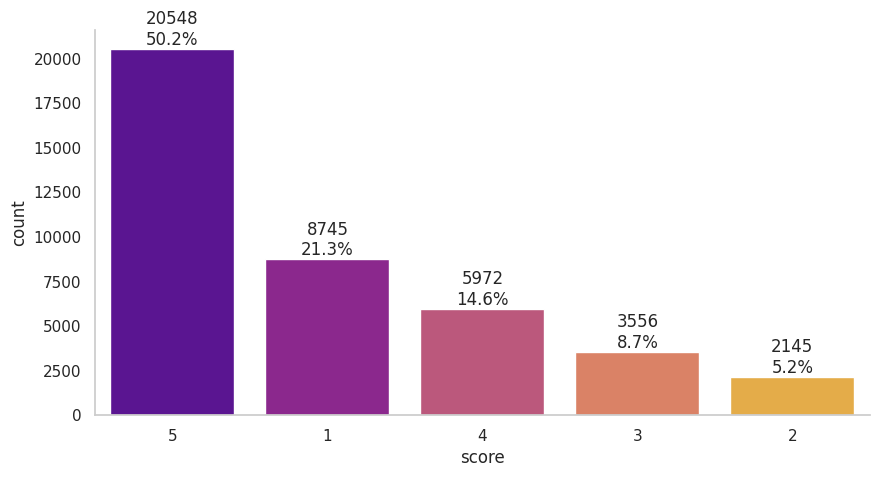

In [86]:
fig, ax = plt.subplots(figsize=(10, 5))
single_countplot(x='score', df=df_comments, ax=ax)

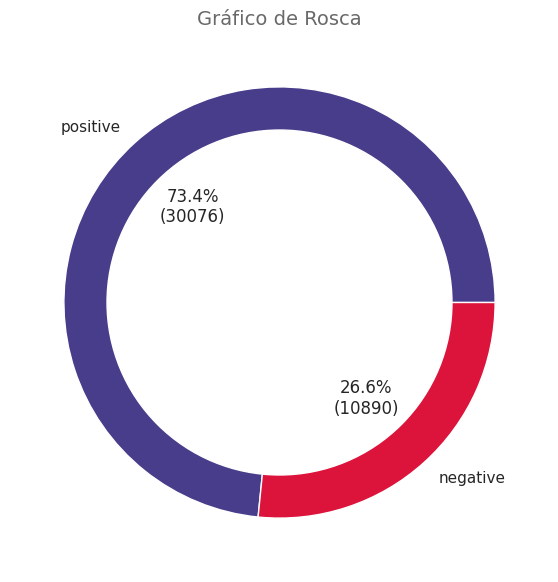

In [87]:
# Labelling data
score_map = {
    1: 'negative',
    2: 'negative',
    3: 'positive',
    4: 'positive',
    5: 'positive'
}
df_comments['sentiment_label'] = df_comments['score'].map(score_map)

# Verifying results
fig, ax = plt.subplots(figsize=(7, 7))
donut_plot(df_comments.query('sentiment_label in ("positive", "negative")'), 'sentiment_label',
           label_names=df_comments.query('sentiment_label in ("positive", "negative")')['sentiment_label'].value_counts().index,
           ax=ax, colors=['darkslateblue', 'crimson'])

In [88]:
def ngrams_count(corpus, ngram_range, n=-1, cached_stopwords=stopwords.words('english')):
    """
    Args
    ----------
    corpus: text to be analysed [type: pd.DataFrame]
    ngram_range: type of n gram to be used on analysis [type: tuple]
    n: top limit of ngrams to be shown [type: int, default: -1]
    """

    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]

    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

In [89]:
# Splitting the corpus into positive and negative comments
positive_comments = df_comments.query('sentiment_label == "positive"')['stemming']
negative_comments = df_comments.query('sentiment_label == "negative"')['stemming']

# Extracting the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)

# Extracting the top 10 unigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)

# Extracting the top 10 unigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)

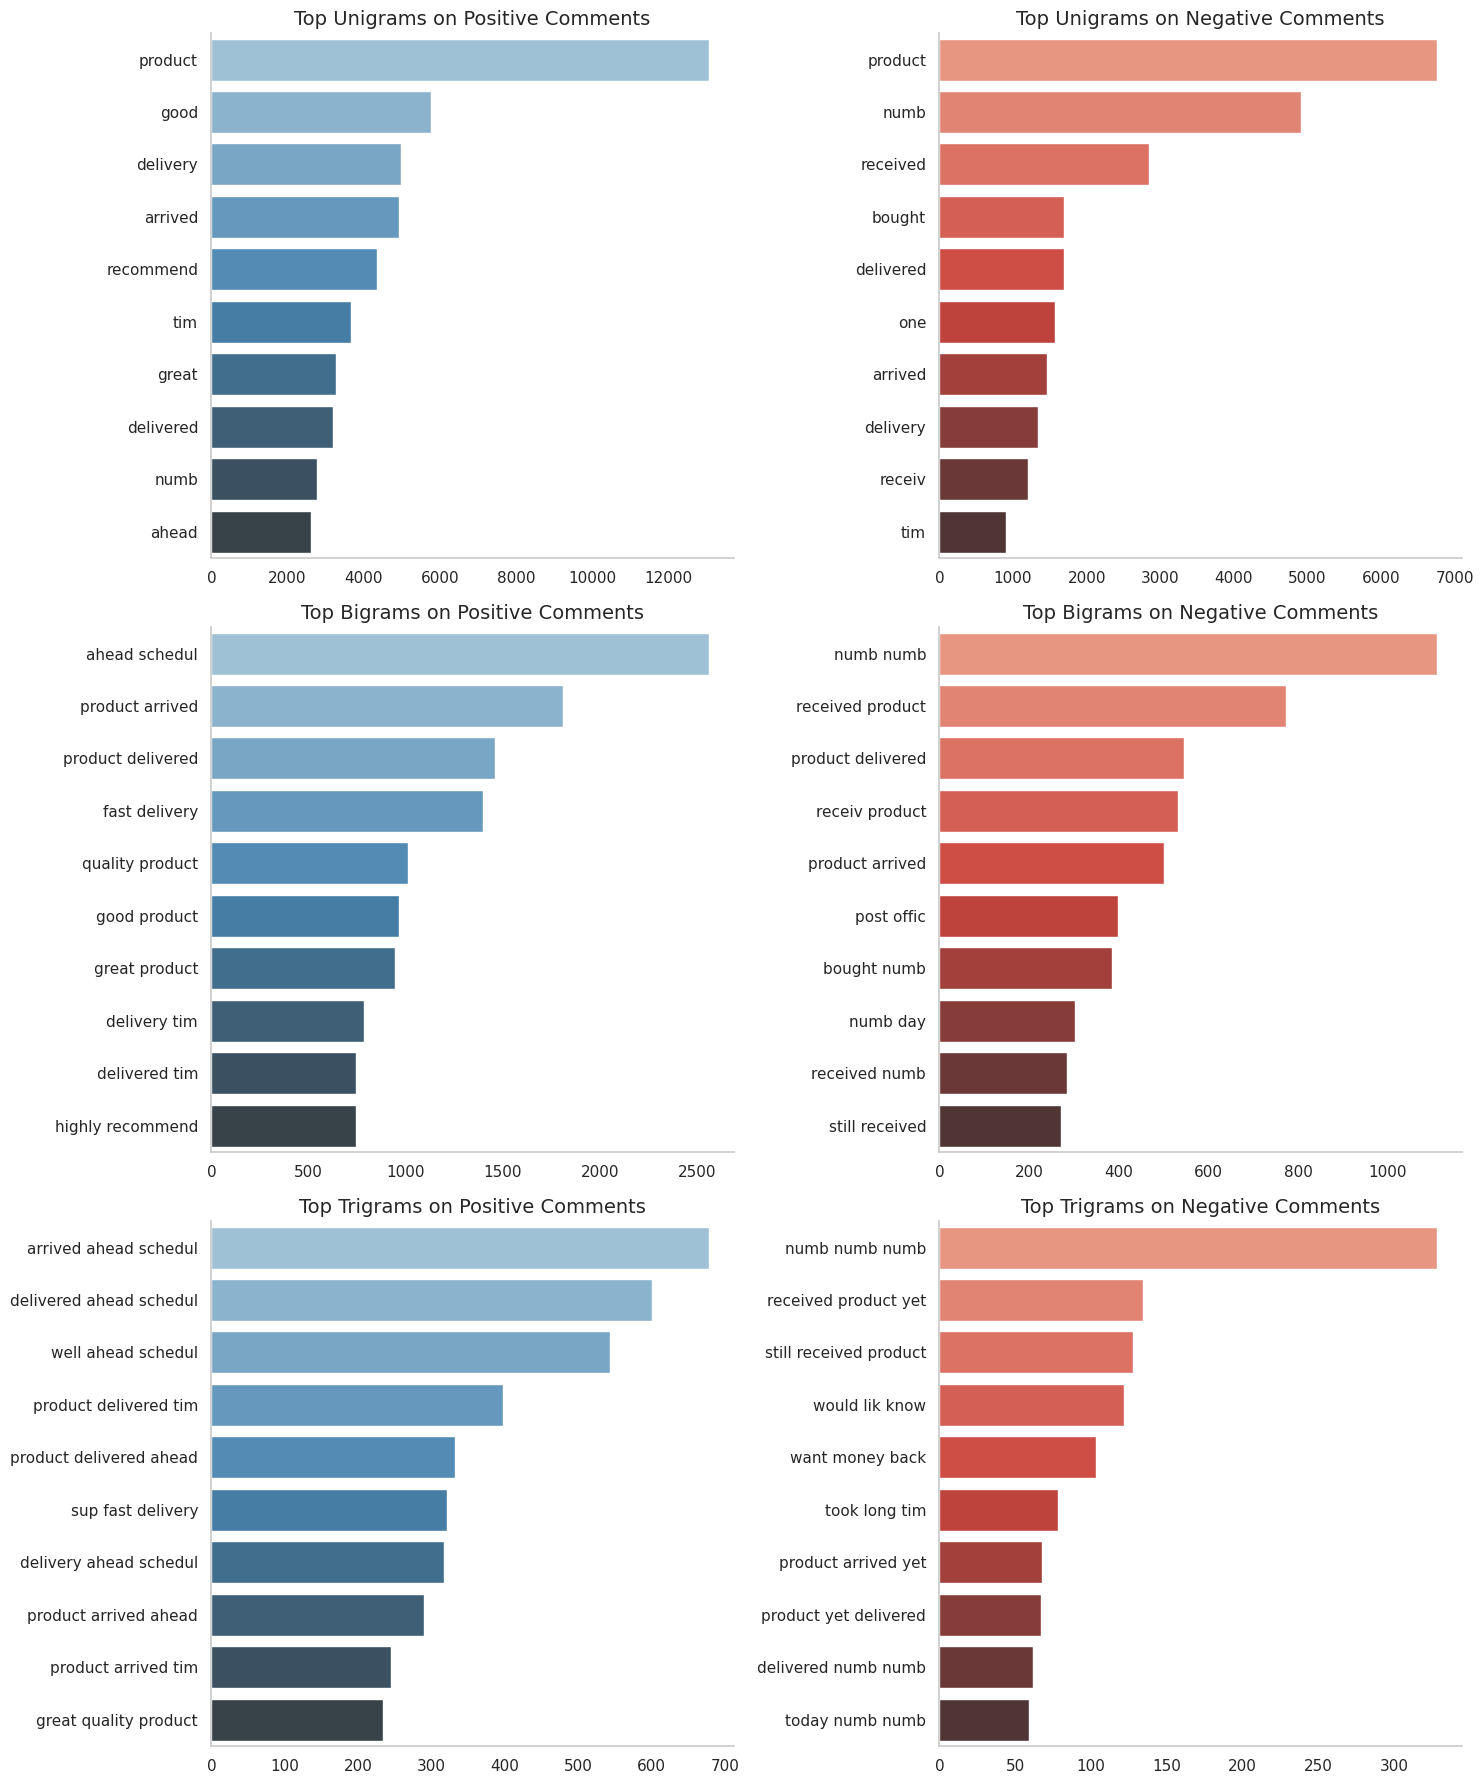

In [90]:
# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])

    # Customizing plots
    format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')

    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1
plt.tight_layout()
plt.show()

# Pipeline

In [91]:
# Class for regular expressions application
class ApplyRegex(BaseEstimator, TransformerMixin):

    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Applying all regex functions in the regex_transformers dictionary
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)

        return X

# Class for stopwords removal from the corpus
class StopWordsRemoval(BaseEstimator, TransformerMixin):

    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [' '.join(stopwords_removal(comment, self.text_stopwords)) for comment in X]

# Class for apply the stemming process
class StemmingProcess(BaseEstimator, TransformerMixin):

    def __init__(self, stemmer):
        self.stemmer = stemmer

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [' '.join(stemming_process(comment, self.stemmer)) for comment in X]

# Class for extracting features from corpus
class TextFeatureExtraction(BaseEstimator, TransformerMixin):

    def __init__(self, vectorizer):
        self.vectorizer = vectorizer

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self.vectorizer.fit_transform(X).toarray()

In [92]:
# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hiperlinks': re_hiperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

# Defining the vectorizer to extract features from text
vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Building the Pipeline
text_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('english'))),
    ('stemming', StemmingProcess(RSLPStemmer())),
    ('text_features', TextFeatureExtraction(vectorizer))
])

In [93]:
# Defining X and y
idx_reviews = olist_order_reviews['review_comment_message'].dropna().index
score = olist_order_reviews['review_score'][idx_reviews].map(score_map)

# Splitting into train and test sets
X = list(olist_order_reviews['review_comment_message'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

# Applying the pipeline and splitting the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.20, random_state=42)

# Verifying results
print(f'Length of X_train_processed: {len(X_train)} - Length of one element: {len(X_train[0])}')
print(f'Length of X_test_processed: {len(X_test)} - Length of one element: {len(X_test[0])}')

Length of X_train_processed: 32772 - Length of one element: 300
Length of X_test_processed: 8194 - Length of one element: 300


# Sentiment Classification

In [94]:
# Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Setting up the classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

In [95]:
# Creating an object and training the classifiers
clf_tool = BinaryClassifiersAnalysis()
clf_tool.fit(set_classifiers, X_train, y_train, random_search=True, scoring='accuracy')

Training model LogisticRegression

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training model Naive Bayes

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [96]:
# Evaluating metrics
df_performances = clf_tool.evaluate_performance(X_train, y_train, X_test, y_test, cv=5)
df_performances.reset_index(drop=True).style.background_gradient(cmap='Blues')

Evaluating model LogisticRegression

Evaluating model Naive Bayes



,model,approach,acc,precision,recall,f1,auc,total_time
0,LogisticRegression,Treino 5 K-folds,0.877400,0.918500,0.914400,0.916400,0.935900,4.340000
1,LogisticRegression,Teste,0.873100,0.912800,0.913400,0.913100,0.935600,0.036000
2,Naive Bayes,Treino 5 K-folds,0.840700,0.941400,0.835400,0.885200,0.882600,4.881000
3,Naive Bayes,Teste,0.848800,0.945500,0.841400,0.890400,0.888000,0.105000


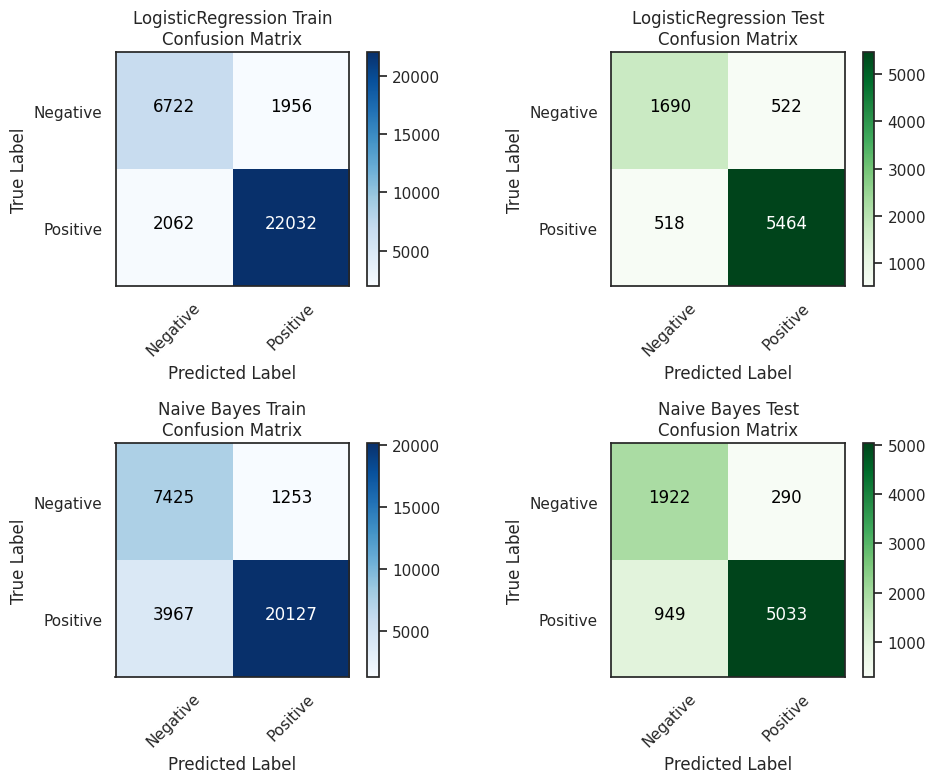

In [97]:
clf_tool.plot_confusion_matrix(classes=['Negative', 'Positive'])

In [98]:
# Defining a function to plot the sentiment of a given phrase
def sentiment_analysis(text, pipeline, vectorizer, model):
    """
    Args
    -----------
    text: text string / phrase / review comment to be analysed [type: string]
    pipeline: text prep pipeline built for preparing the corpus [type: sklearn.Pipeline]
    model: classification model trained to recognize positive and negative sentiment [type: model]
    """

    # Applying the pipeline
    if type(text) is not list:
        text = [text]
    text_prep = pipeline.fit_transform(text)
    matrix = vectorizer.transform(text_prep)

    # Predicting sentiment
    pred = model.predict(matrix)
    proba = model.predict_proba(matrix)

    # Plotting the sentiment and its score
    fig, ax = plt.subplots(figsize=(5, 3))
    if pred[0] == 1:
        text = 'Positive'
        class_proba = 100 * round(proba[0][1], 2)
        color = 'seagreen'
    else:
        text = 'Negative'
        class_proba = 100 * round(proba[0][0], 2)
        color = 'crimson'
    ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
    ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha='center')
    ax.axis('off')
    ax.set_title('Sentiment Analysis', fontsize=14)
    plt.show()

# Final Implementation

In [99]:
# Defining transformers for preparing the text input
model = clf_tool.classifiers_info['LogisticRegression']['estimator']
prod_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('english'))),
    ('stemming', StemmingProcess(RSLPStemmer()))
])
vectorizer = text_pipeline.named_steps['text_features'].vectorizer

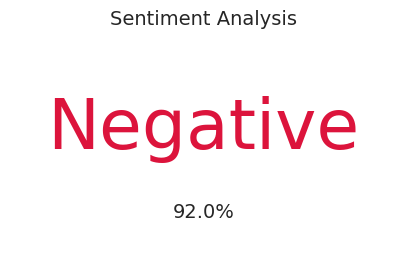

In [100]:
comment = "Terrible product! I don't buy from this store, the delivery was late and cost a lot of money!"
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

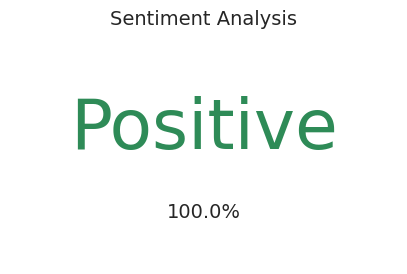

In [101]:
comment = 'I loved it and it really lived up to expectations. I bought it for a cheap price. Wonderful'
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

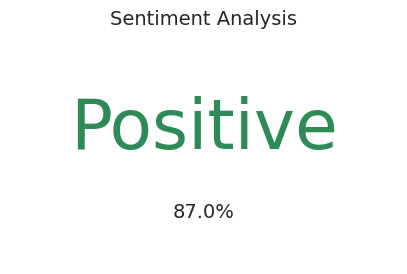

In [102]:
comment = "I don't know, I liked the product. The cost was cheap but it arrived defective. If you're lucky, it's worth it"
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

In [103]:
"""
This python script will allocate all the custom transformers that are specific for the project task.
The idea is to encapsulate the classes and functions used on pipelines to make codes cleaner.
"""

# Importing libraries
from sklearn.base import BaseEstimator, TransformerMixin


"""
-----------------------------------
----- 1. CUSTOM TRANSFORMERS ------
           1.1 Classes
-----------------------------------
"""


class ColumnMapping(BaseEstimator, TransformerMixin):
    """
    This class applies the map() function into a DataFrame for transforming a columns given a mapping dictionary

    Parameters
    ----------
    :param old_col_name: name of the columns where mapping will be applied [type: string]
    :param mapping_dict: python dictionary with key/value mapping [type: dict]
    :param new_col_name: name of the new column resulted by mapping [type: string, default: 'target]
    :param drop: flag that guides the dropping of the old_target_name column [type: bool, default: True]

    Returns
    -------
    :return X: pandas DataFrame object after mapping application [type: pd.DataFrame]

    Application
    -----------
    # Transforming a DataFrame column given a mapping dictionary
    mapper = ColumnMapping(old_col_name='col_1', mapping_dict=dictionary, new_col_name='col_2', drop=True)
    df_mapped = mapper.fit_transform(df)
    """

    def __init__(self, old_col_name, mapping_dict, new_col_name='target', drop=True):
        self.old_col_name = old_col_name
        self.mapping_dict = mapping_dict
        self.new_col_name = new_col_name
        self.drop = drop

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Applying mpping
        X[self.new_col_name] = X[self.old_col_name].map(self.mapping_dict)

        # Dropping the old columns (if applicable)
        if self.drop:
            X.drop(self.old_col_name, axis=1, inplace=True)

        return X

In [104]:
"""
This python script are responsible for reading, preparing and training a sentiment classification model from
e-commerce reviews taken from brazilian web-sites


--- SUMMARY ---

1. Project Variables
2. Reading Data
3. Prep Pipelines
    3.1 Initial Preparation
    3.2 Text Transformers
4. Modeling
    4.1 Model Training
    4.2 Evaluating Metrics
    4.3 Complete Solution
    4.4 Final Model Performance
    4.5 Saving pkl Files

"""


# Importing libs
import os
import numpy as np
import pandas as pd
#from dev.training.project_transformers import ColumnMapping
from custom_transformers import import_data, DropNullData, DropDuplicates
from text_utils import re_breakline, re_dates, re_hiperlinks, re_money, re_negation, re_numbers, \
    re_special_chars, re_whitespaces, ApplyRegex, StemmingProcess, StopWordsRemoval
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from joblib import dump
from sklearn.linear_model import LogisticRegression
from ml_utils import BinaryClassifiersAnalysis, cross_val_performance
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve


"""
-----------------------------------
------ 1. PROJECT VARIABLES -------
-----------------------------------
"""

# Variables for address paths
DATA_PATH = ''
PIPELINES_PATH = '/content/pipelines' # Take a look at your project structure
MODELS_PATH = '/content/models' # Take a look at your project structure

# Variables for reading the data
FILENAME = 'olist_order_reviews_dataset.csv'
COLS_READ = ['review_comment_message', 'review_score']
CORPUS_COL = 'review_comment_message'
TARGET_COL = 'target'

# Defining stopwords
nltk.download('stopwords')
PT_STOPWORDS = stopwords.words('english')

# Variables for saving data
METRICS_FILEPATH = '/content/metrics/model_performance.csv' # Take a look at your project structure

# Variables for retrieving model
MODEL_KEY = 'LogisticRegression'


"""
-----------------------------------
-------- 2. READING DATA ----------
-----------------------------------
"""

# Reading the data with text corpus and score
df = import_data(os.path.join(DATA_PATH, FILENAME), usecols=COLS_READ)


"""
-----------------------------------
------- 3. PREP PIPELINES ---------
    3.1 Initial Preparation
-----------------------------------
"""

# Creating a dictionary for mapping the target column based on review score
score_map = {
    1: 0,
    2: 0,
    3: 0,
    4: 1,
    5: 1
}

# Creating a pipeline for the initial prep on the data
initial_prep_pipeline = Pipeline([
    ('mapper', ColumnMapping(old_col_name='review_score', mapping_dict=score_map, new_col_name=TARGET_COL)),
    ('null_dropper', DropNullData()),
    ('dup_dropper', DropDuplicates())
])

# Applying initial prep pipeline
df_prep = initial_prep_pipeline.fit_transform(df)


"""
-----------------------------------
------- 3. PREP PIPELINES ---------
      3.2 Text Transformers
-----------------------------------
"""

# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hiperlinks': re_hiperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

# Building a text prep pipeline
text_prep_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(PT_STOPWORDS)),
    ('stemming', StemmingProcess(RSLPStemmer())),
    ('vectorizer', TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=PT_STOPWORDS))
])

# Applying the pipeline
X = df_prep[CORPUS_COL].tolist()
y = df_prep[TARGET_COL]
X_prep = text_prep_pipeline.fit_transform(X)

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=.20, random_state=42)

# Saving states before prep pipeline


"""
-----------------------------------
--------- 4. MODELING  -----------
       4.1 Model Training
-----------------------------------
"""

# Specifing a Logistic Regression model for sentiment classification
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Setting up the classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    }
}

# Creating an object and training the classifiers
trainer = BinaryClassifiersAnalysis()
trainer.fit(set_classifiers, X_train, y_train, random_search=True, scoring='accuracy')


"""
-----------------------------------
--------- 4. MODELING  -----------
    4.2 Evaluating Metrics
-----------------------------------
"""

# Evaluating metrics
performance = trainer.evaluate_performance(X_train, y_train, X_test, y_test, cv=5, save=False,
                                           performances_filepath=METRICS_FILEPATH) # In your project env, save=True and overwrite=True may be useful


"""
-----------------------------------
--------- 4. MODELING  -----------
    4.3. Complete Solution
-----------------------------------
"""

# Returning the model to be saved
model = trainer.classifiers_info[MODEL_KEY]['estimator']

# Creating a complete pipeline for prep and predict
e2e_pipeline = Pipeline([
    ('text_prep', text_prep_pipeline),
    ('model', model)
])

# Defining a param grid for searching best pipelines options (reduced options for making the search faster)
"""param_grid = [{
    'text_prep__vectorizer__max_features': np.arange(500, 851, 50),
    'text_prep__vectorizer__min_df': [7, 9, 12, 15, 30],
    'text_prep__vectorizer__max_df': [.4, .5, .6, .7]
}]"""

param_grid = [{
    'text_prep__vectorizer__max_features': np.arange(500, 501, 50),
    'text_prep__vectorizer__min_df': [7],
    'text_prep__vectorizer__max_df': [.4]
}]

# Searching for best options
grid_search_prep = GridSearchCV(e2e_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_prep.fit(X, y)
print('Best params after a complete search:')
print(grid_search_prep.best_params_)

# Returning the best options
vectorizer_max_features = grid_search_prep.best_params_['text_prep__vectorizer__max_features']
vectorizer_min_df = grid_search_prep.best_params_['text_prep__vectorizer__min_df']
vectorizer_max_df = grid_search_prep.best_params_['text_prep__vectorizer__max_df']

# Updating the e2e pipeline with the best options found on search
e2e_pipeline.named_steps['text_prep'].named_steps['vectorizer'].max_features = vectorizer_max_features
e2e_pipeline.named_steps['text_prep'].named_steps['vectorizer'].min_df = vectorizer_min_df
e2e_pipeline.named_steps['text_prep'].named_steps['vectorizer'].max_df = vectorizer_max_df

# Fitting the model again
e2e_pipeline.fit(X, y)


"""
-----------------------------------
--------- 4. MODELING  -----------
    4.4 Final Model Performance
-----------------------------------
"""

# Retrieving performance for te final model after hyperparam updating
final_model = e2e_pipeline.named_steps['model']
final_performance = cross_val_performance(final_model, X_prep, y, cv=5)
final_performance = pd.concat([final_performance,performance ])
print(final_performance)
#final_performance.to_csv(METRICS_FILEPATH, index=False)


"""
-----------------------------------
--------- 4. MODELING  -----------
      4.5 Saving pkl files
-----------------------------------
"""

# Creating folders for saving pkl files (if not exists)
if not os.path.exists('/content/models'):
    os.makedirs('/content/models')
if not os.path.exists('/content/pipelines'):
    os.makedirs('/content/pipelines')

# Saving pkl files
dump(initial_prep_pipeline, os.path.join(PIPELINES_PATH, 'initial_prep_pipeline.pkl'))
dump(text_prep_pipeline, os.path.join(PIPELINES_PATH, 'text_prep_pipeline.pkl'))
dump(e2e_pipeline, os.path.join(PIPELINES_PATH, 'e2e_pipeline.pkl'))
dump(final_model, os.path.join(MODELS_PATH, 'sentiment_clf_model.pkl'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This dataset has 2 columns, which 1 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0009 MB
Memory usage after optimization (50 lines): 0.0007 MB
----------------------------------------------------

Reduction of 21.55% on memory usage

Training model LogisticRegression

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Evaluating model LogisticRegression

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params after a complete search:
{'text_prep__vectorizer__max_df': 0.4, 'text_prep__vectorizer__max_features': 500, 'text_prep__vectorizer__min_df': 7}
  anomesdia         anomesdia_datetime               model          approach  \
0  20240424 2024-04-24 08:08:31.961353  LogisticRegression       Final Model   
0       NaN                        NaT  LogisticRegression  Treino 5 K-folds   
0       NaN                        NaT  LogisticRegression             Teste   

      acc  precision  reca

['/content/models/sentiment_clf_model.pkl']

In [105]:
from joblib import load

# Specify the paths to your pickle files
initial_prep_pipeline_path = '/content/pipelines/initial_prep_pipeline.pkl'
e2e_pipeline_path = '/content/pipelines/e2e_pipeline.pkl'

# Load the pipelines using joblib
initial_prep_pipeline = joblib.load(initial_prep_pipeline_path)
e2e_pipeline = joblib.load(e2e_pipeline_path)

In [106]:
# new_data = pd.DataFrame({
#     'review_comment_message': [
#         'This product is fantastic! Highly recommended.',  # Positive review
#         'The quality is terrible. I wouldn\'t buy it again.',  # Negative review
#         "It's okay, but not as good as I expected.",  # Neutral/Slightly negative review
#         'Amazing product! Exceeded my expectations.',  # Positive review
#         'Waste of money. Don\'t bother.',  # Negative review
#     ],
#     'review_score': [5, 1, 3, 5, 2]  # Corresponding review scores
# })

review_data = olist_order_reviews.loc[:, ['review_comment_message', 'review_score']]
review_data = review_data.dropna(subset=['review_comment_message'])
review_data = review_data.reset_index(drop=True)


new_data_prepped = initial_prep_pipeline.transform(review_data)

predictions = e2e_pipeline.predict(new_data_prepped['review_comment_message'])
prediction_probabilities = e2e_pipeline.predict_proba(new_data_prepped['review_comment_message'])


sentiment_counts = pd.Series(predictions).value_counts()
probabilites_counts = prediction_probabilities

positive_count = sentiment_counts.get(1, 0)  # Get count of 1s, default to 0 if not found
negative_count = sentiment_counts.get(0, 0)  # Get count of 0s, default to 0 if not found

# print("Probability (Positive): ", positive_count)
# print("Probability (Negative): ", negative_count)
# print(probabilites_counts)

for i, prediction in enumerate(predictions[:10]):
    print(f"Review {i+1}:")
    print(f"Predicted Sentiment: {'Positive' if prediction == 1 else 'Negative'}")
    print(f"Probability (Positive): {prediction_probabilities[i][1]:.2f}")
    print(f"Probability (Negative): {prediction_probabilities[i][0]:.2f}")
    print("-" * 20)

Review 1:
Predicted Sentiment: Positive
Probability (Positive): 0.95
Probability (Negative): 0.05
--------------------
Review 2:
Predicted Sentiment: Positive
Probability (Positive): 1.00
Probability (Negative): 0.00
--------------------
Review 3:
Predicted Sentiment: Negative
Probability (Positive): 0.32
Probability (Negative): 0.68
--------------------
Review 4:
Predicted Sentiment: Negative
Probability (Positive): 0.43
Probability (Negative): 0.57
--------------------
Review 5:
Predicted Sentiment: Positive
Probability (Positive): 0.96
Probability (Negative): 0.04
--------------------
Review 6:
Predicted Sentiment: Negative
Probability (Positive): 0.32
Probability (Negative): 0.68
--------------------
Review 7:
Predicted Sentiment: Negative
Probability (Positive): 0.00
Probability (Negative): 1.00
--------------------
Review 8:
Predicted Sentiment: Negative
Probability (Positive): 0.41
Probability (Negative): 0.59
--------------------
Review 9:
Predicted Sentiment: Positive
Probabil